In [1]:
import gymnasium as gym
from mountaincar_wrapper import MountainCarWrapper
from bettermdptools.utils.test_env import TestEnv
from bettermdptools.algorithms.planner import Planner
from bettermdptools.utils.plots import Plots
from rl import RL
from myutils import test_env
#from expected_reward_history import expected_reward_history
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time

from planner import PlannerR

In [ ]:
# https://github.com/feknall/gym-mountain-car/blob/master/mountain_car_v0.py

In [9]:
force = 0.001
gravity = 0.0025
action = 2
positiont = 0
velocityt = 0
velocityt1 = velocityt + (action - 1) * force - np.cos(3 * positiont) * gravity
velocityt1

-0.0015

#### VI - Impact of discretization

In [2]:
from multiprocessing import Pool
import workers_a4
import os

def expected_reward_history(space_dims, pi_track, output_step, n_episodes=1000, nproc=4):
    e_track = list(range(0, len(pi_track), output_step)) + [len(pi_track)-1]
    parameters = []
    output_file = 'temp'
    for e in e_track:
        parameters.append((space_dims, e, pi_track[e], n_episodes, output_file))
        
    if __name__ ==  '__main__':
        p=Pool(processes = nproc)
        p.map(workers_a4.mc_expected_reward, parameters)

    R_track = np.loadtxt(output_file, delimiter=' ')
    R_track = R_track[R_track[:, 0].argsort()]
    os.remove(output_file)

    return R_track

In [3]:
def test_env_mc(env, n_iters, pi, convert_state_obs=lambda state: state):
    test_scores = np.full([n_iters], np.nan)
    test_state_history = []
    for i in range(0, n_iters):
        state_iter = []
        state, info = env.reset(seed=i)
        done = False
        state = convert_state_obs(state)
        total_reward = 0
        while not done:
            state_iter.append(state)
            action = pi[state]
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            next_state = convert_state_obs(next_state)
            state = next_state
            total_reward += reward
        test_scores[i] = total_reward
        test_state_history.append(state_iter)
        env.close()
    return test_scores, test_state_history

def index_to_position_list(state_index_history, position_range, position_bins, velocity_bins):
    position_idx = np.unravel_index(state_index_history, (position_bins, velocity_bins), order='C')[0]
    return np.linspace(*position_range, position_bins)[position_idx]
    

In [4]:
print('Calculating transition matrix')
base_env = gym.make('MountainCar-v0', render_mode=None)
space_dims = (200, 200)
tic = time.perf_counter()
mountaincar200 = MountainCarWrapper(base_env, position_bins=space_dims[0], velocity_bins=space_dims[1], model=True)
toc = time.perf_counter()
print('Time to create environment and build transition matrix', toc-tic)

Calculating transition matrix
Time to create environment and build transition matrix 58.93034770002123


Running VI
VI runtime 17.197581799933687


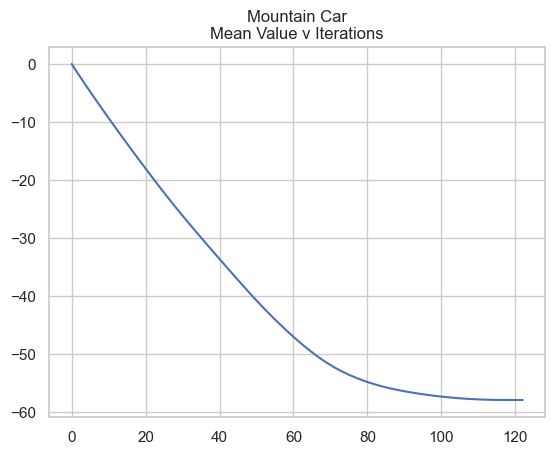

Computing expected reward history


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


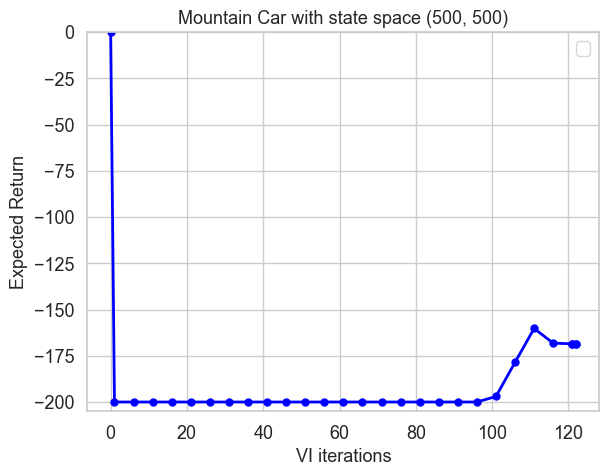

In [5]:
space_dims = (200, 200)

print('Running VI')
# run VI
tic = time.perf_counter()
V, V_track, pi, pi_track = PlannerR(mountaincar200.P, mountaincar200).value_iteration(gamma=1.0, n_iters=1000, theta=1e-10)
toc = time.perf_counter()
print('VI runtime', toc-tic)

# Clip trailing zeros in case convergence is reached before max iterations
# This is likely when setting the n_iters parameter
mean_v_per_iter = np.trim_zeros(np.mean(V_track, axis=1), 'b')
Plots.v_iters_plot(mean_v_per_iter, "Mountain Car\nMean Value v Iterations")

print('Computing expected reward history')
R_track = expected_reward_history(space_dims=space_dims, pi_track=pi_track, output_step=5, n_episodes=10000, nproc=8)

R_track[:, 0] = R_track[:, 0] + 1
row_of_zeros = np.zeros((1, 3))
R_track = np.vstack((row_of_zeros, R_track))

R_track1 = R_track

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(R_track[:,0], R_track[:,1], '-o', color='blue', markersize=5, linewidth=2)

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car with state space (500, 500)', fontsize=fontsize)
ax.set_xlabel('VI iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
ax.legend(fontsize=fontsize)
ax.set_ylim(-205, 0)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

In [6]:
print('Calculating transition matrix')
base_env = gym.make('MountainCar-v0', render_mode=None)
space_dims = (500, 500)
tic = time.perf_counter()
mountaincar500 = MountainCarWrapper(base_env, position_bins=space_dims[0], velocity_bins=space_dims[1], model=True)
toc = time.perf_counter()
print('Time to create environment and build transition matrix', toc-tic)

Calculating transition matrix
Time to create environment and build transition matrix 370.20661759993527


Running VI
VI runtime 99.681350100087


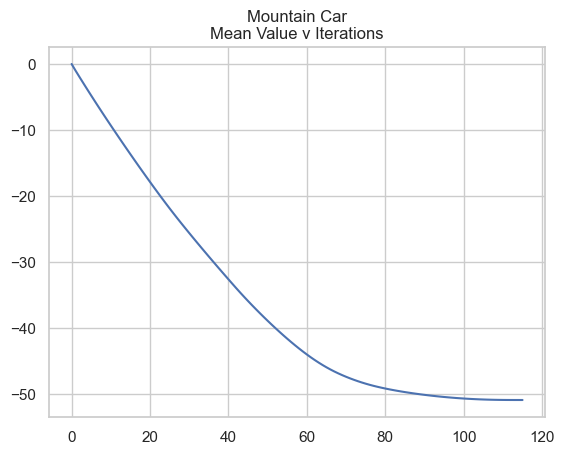

Computing expected reward history


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


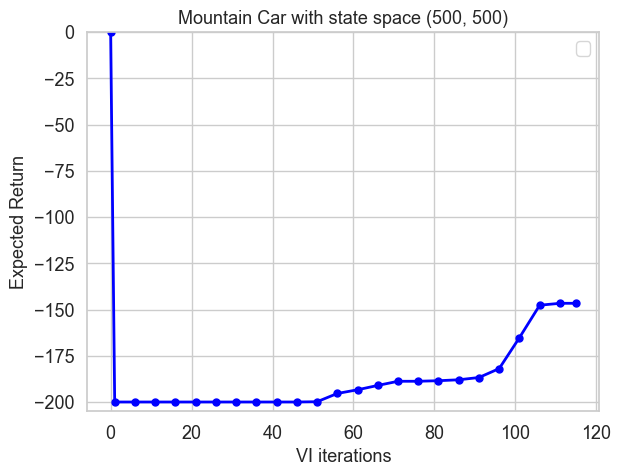

In [7]:
space_dims = (500, 500)

print('Running VI')
# run VI
tic = time.perf_counter()
V, V_track, pi, pi_track = PlannerR(mountaincar500.P, mountaincar500).value_iteration(gamma=1.0, n_iters=1000, theta=1e-10)
toc = time.perf_counter()
print('VI runtime', toc-tic)
# Clip trailing zeros in case convergence is reached before max iterations
# This is likely when setting the n_iters parameter
mean_v_per_iter = np.trim_zeros(np.mean(V_track, axis=1), 'b')
Plots.v_iters_plot(mean_v_per_iter, "Mountain Car\nMean Value v Iterations")

print('Computing expected reward history')
R_track = expected_reward_history(space_dims=space_dims, pi_track=pi_track, output_step=5, n_episodes=10000, nproc=8)

R_track[:, 0] = R_track[:, 0] + 1
row_of_zeros = np.zeros((1, 3))
R_track = np.vstack((row_of_zeros, R_track))

R_track2 = R_track

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(R_track[:,0], R_track[:,1], '-o', color='blue', markersize=5, linewidth=2)

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car with state space (500, 500)', fontsize=fontsize)
ax.set_xlabel('VI iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
ax.legend(fontsize=fontsize)
ax.set_ylim(-205, 0)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

In [8]:
print('Calculating transition matrix')
base_env = gym.make('MountainCar-v0', render_mode=None)
space_dims = (1000, 1000)
tic = time.perf_counter()
mountaincar1000 = MountainCarWrapper(base_env, position_bins=space_dims[0], velocity_bins=space_dims[1], model=True)
toc = time.perf_counter()
print('Time to create environment and build transition matrix', toc-tic)


Calculating transition matrix
Time to create environment and build transition matrix 1500.486468099989


Running VI
VI runtime 396.8113151999423


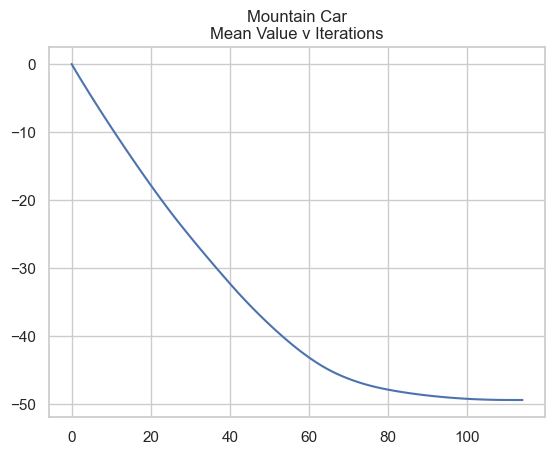

Computing expected reward history


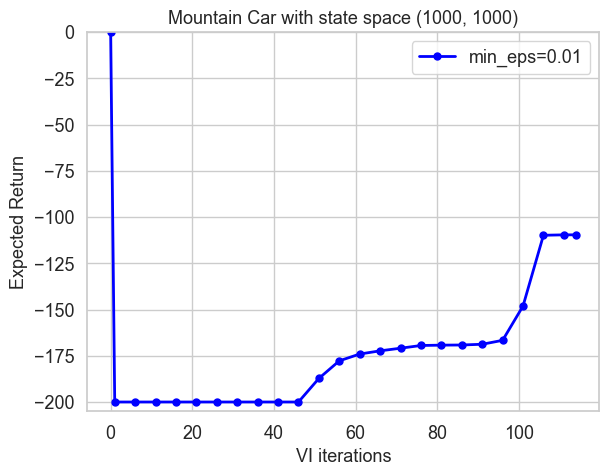

In [9]:
space_dims = (1000, 1000)

print('Running VI')
# run VI
tic = time.perf_counter()
V, V_track, pi, pi_track = PlannerR(mountaincar1000.P, mountaincar1000).value_iteration(gamma=1.0, n_iters=200, theta=1e-10)
toc = time.perf_counter()
print('VI runtime', toc-tic)
# Clip trailing zeros in case convergence is reached before max iterations
# This is likely when setting the n_iters parameter
mean_v_per_iter = np.trim_zeros(np.mean(V_track, axis=1), 'b')
Plots.v_iters_plot(mean_v_per_iter, "Mountain Car\nMean Value v Iterations")

print('Computing expected reward history')
R_track = expected_reward_history(space_dims=space_dims, pi_track=pi_track, output_step=5, n_episodes=10000, nproc=8)

R_track[:, 0] = R_track[:, 0] + 1
row_of_zeros = np.zeros((1, 3))
R_track = np.vstack((row_of_zeros, R_track))

V_track3 = V_track 
R_track3 = R_track
V3 = V
pi3 = pi 
pi_track3 = pi_track

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(R_track[:,0], R_track[:,1], '-o', color='blue', label='min_eps=0.01', markersize=5, linewidth=2)

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car with state space (1000, 1000)', fontsize=fontsize)
ax.set_xlabel('VI iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
ax.legend(fontsize=fontsize)
ax.set_ylim(-205, 0)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

In [74]:
mountaincar1000.observation_space

1000000

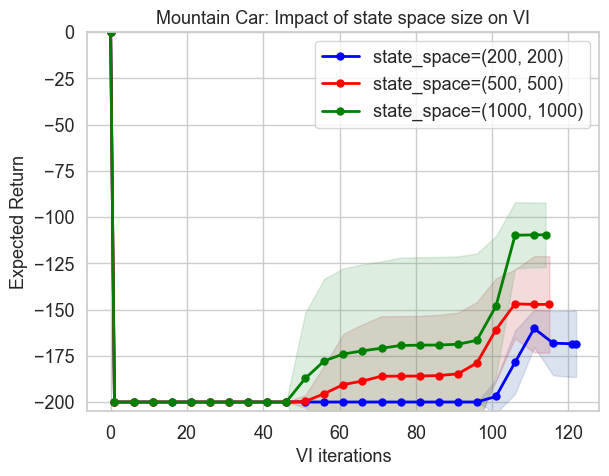

In [35]:
fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(R_track1[:,0], R_track1[:,1], '-o', color='blue', label='state_space=(200, 200)', markersize=5, linewidth=2)
ax.fill_between(R_track1[:,0], R_track1[:,1]-R_track1[:,2], R_track1[:,1]+R_track1[:,2], alpha=0.2, color="b")

ax.plot(R_track2[:,0], R_track2[:,1], '-o', color='red', label='state_space=(500, 500)', markersize=5, linewidth=2)
ax.fill_between(R_track2[:,0], R_track2[:,1]-R_track2[:,2], R_track2[:,1]+R_track2[:,2], alpha=0.2, color="r")

ax.plot(R_track3[:,0], R_track3[:,1], '-o', color='green', label='state_space=(1000, 1000)', markersize=5, linewidth=2)
ax.fill_between(R_track3[:,0], R_track3[:,1]-R_track3[:,2], R_track3[:,1]+R_track3[:,2], alpha=0.2, color="g")

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car: Impact of state space size on VI', fontsize=fontsize)
ax.set_xlabel('VI iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
ax.legend(fontsize=fontsize)
ax.set_ylim(-205, 0)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

In [36]:
print(R_track1[-1,1], R_track2[-1,1], R_track3[-1,1])

-168.5117 -147.24 -109.628


#### Impact of discount factor

Running VI


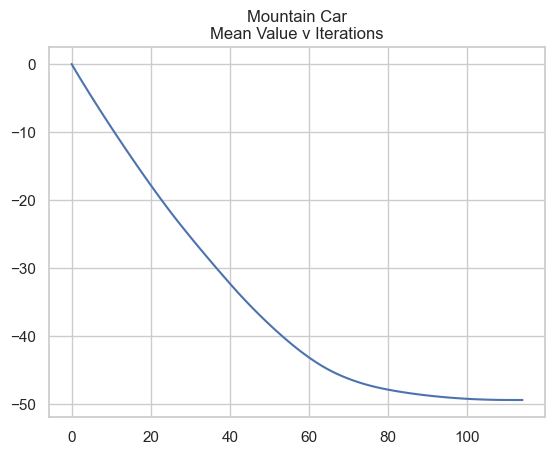

Computing expected reward history


In [28]:
space_dims = (1000, 1000)
print('Running VI')
# run VI
V, V_track, pi, pi_track = PlannerR(mountaincar1000.P, mountaincar1000).value_iteration(gamma=1.0, n_iters=1000, theta=1e-10)
# Clip trailing zeros in case convergence is reached before max iterations
# This is likely when setting the n_iters parameter
mean_v_per_iter = np.trim_zeros(np.mean(V_track, axis=1), 'b')
Plots.v_iters_plot(mean_v_per_iter, "Mountain Car\nMean Value v Iterations")

print('Computing expected reward history')
R_track = expected_reward_history(space_dims=space_dims, pi_track=pi_track, output_step=5, n_episodes=100, nproc=8)

R_track[:, 0] = R_track[:, 0] + 1
row_of_zeros = np.zeros((1, 3))
R_track = np.vstack((row_of_zeros, R_track))

V_track3 = V_track 
R_track3 = R_track
V3 = V
pi3 = pi 
pi_track3 = pi_track

In [12]:
V3 = V

In [72]:
print('Running VI')
# run VI
space_dims = (1000, 1000)
tic = time.perf_counter()
V, V_track, pi, pi_track = PlannerR(mountaincar1000.P, mountaincar1000).value_iteration(gamma=0.5, n_iters=200, theta=1e-10)
toc = time.perf_counter()
print('PI runtime', toc-tic)

Running VI
PI runtime 121.77807299990673


Running VI
PI runtime 121.74679989996366


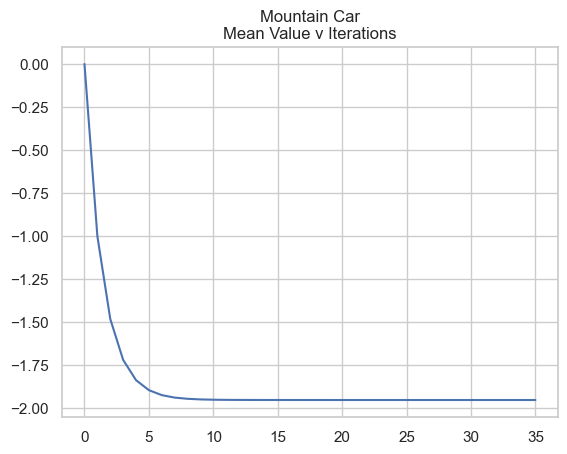

Computing expected reward history


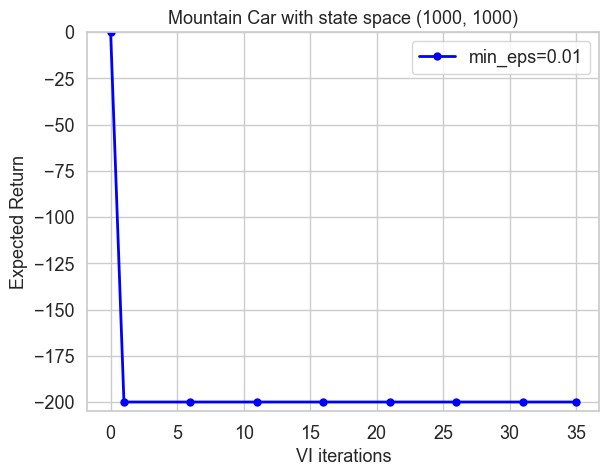

In [14]:
print('Running VI')
# run VI
space_dims = (1000, 1000)
tic = time.perf_counter()
V, V_track, pi, pi_track = PlannerR(mountaincar1000.P, mountaincar1000).value_iteration(gamma=0.5, n_iters=200, theta=1e-10)
toc = time.perf_counter()
print('PI runtime', toc-tic)
# Clip trailing zeros in case convergence is reached before max iterations
# This is likely when setting the n_iters parameter
mean_v_per_iter = np.trim_zeros(np.mean(V_track, axis=1), 'b')
Plots.v_iters_plot(mean_v_per_iter, "Mountain Car\nMean Value v Iterations")

print('Computing expected reward history')
R_track = expected_reward_history(space_dims=space_dims, pi_track=pi_track, output_step=5, n_episodes=10000, nproc=8)

R_track[:, 0] = R_track[:, 0] + 1
row_of_zeros = np.zeros((1, 3))
R_track = np.vstack((row_of_zeros, R_track))

V_track3g05 = V_track 
R_track3g05 = R_track
V3g05 = V
pi3g05 = pi 
pi_track3g05 = pi_track

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(R_track[:,0], R_track[:,1], '-o', color='blue', label='min_eps=0.01', markersize=5, linewidth=2)

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car with state space (1000, 1000)', fontsize=fontsize)
ax.set_xlabel('VI iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
ax.legend(fontsize=fontsize)
ax.set_ylim(-205, 0)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

Running VI
PI runtime 286.3790516000008


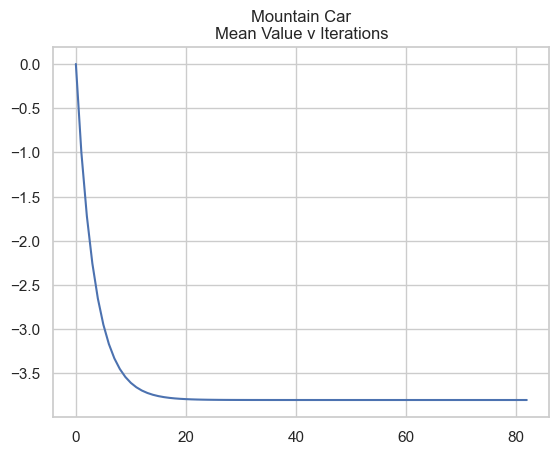

Computing expected reward history


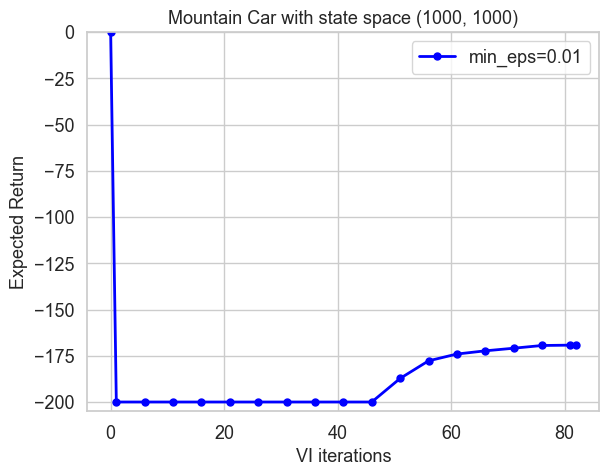

In [15]:
print('Running VI')
# run VI
space_dims = (1000, 1000)
tic = time.perf_counter()
V, V_track, pi, pi_track = PlannerR(mountaincar1000.P, mountaincar1000).value_iteration(gamma=0.75, n_iters=200, theta=1e-10)
toc = time.perf_counter()
print('PI runtime', toc-tic)
# Clip trailing zeros in case convergence is reached before max iterations
# This is likely when setting the n_iters parameter
mean_v_per_iter = np.trim_zeros(np.mean(V_track, axis=1), 'b')
Plots.v_iters_plot(mean_v_per_iter, "Mountain Car\nMean Value v Iterations")

print('Computing expected reward history')
R_track = expected_reward_history(space_dims=space_dims, pi_track=pi_track, output_step=5, n_episodes=10000, nproc=8)

R_track[:, 0] = R_track[:, 0] + 1
row_of_zeros = np.zeros((1, 3))
R_track = np.vstack((row_of_zeros, R_track))

V_track3g07 = V_track 
R_track3g07 = R_track
V3g07 = V
pi3g07 = pi 
pi_track3g07 = pi_track

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(R_track[:,0], R_track[:,1], '-o', color='blue', label='min_eps=0.01', markersize=5, linewidth=2)

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car with state space (1000, 1000)', fontsize=fontsize)
ax.set_xlabel('VI iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
ax.legend(fontsize=fontsize)
ax.set_ylim(-205, 0)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

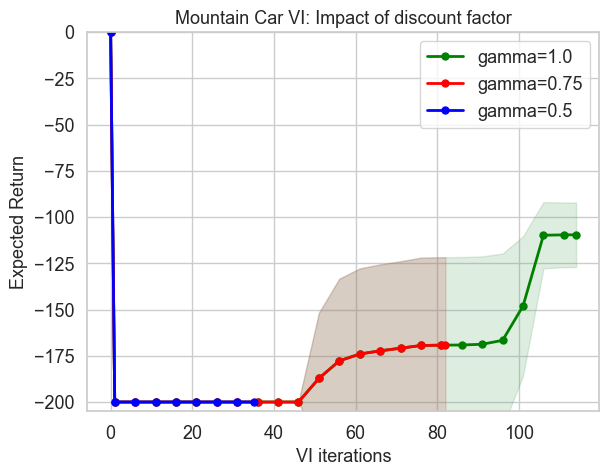

In [16]:
fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(R_track3[:,0], R_track3[:,1], '-o', color='green', label='gamma=1.0', markersize=5, linewidth=2)
ax.fill_between(R_track3[:,0], R_track3[:,1]-R_track3[:,2], R_track3[:,1]+R_track3[:,2], alpha=0.2, color="g")

ax.plot(R_track3g07[:,0], R_track3g07[:,1], '-o', color='red', label='gamma=0.75', markersize=5, linewidth=2)
ax.fill_between(R_track3g07[:,0], R_track3g07[:,1]-R_track3g07[:,2], R_track3g07[:,1]+R_track3g07[:,2], alpha=0.2, color="r")

ax.plot(R_track3g05[:,0], R_track3g05[:,1], '-o', color='blue', label='gamma=0.5', markersize=5, linewidth=2)
ax.fill_between(R_track3g05[:,0], R_track3g05[:,1]-R_track3g05[:,2], R_track3g05[:,1]+R_track3g05[:,2], alpha=0.2, color="b")

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car VI: Impact of discount factor', fontsize=fontsize)
ax.set_xlabel('VI iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
ax.legend(fontsize=fontsize)
ax.set_ylim(-205, 0)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

In [17]:
R_track3g05

NameError: name 'R_track3g05' is not defined

Total reward Mean:  -109.628 , std:  17.4622053590032 , max:  -85.0 , min:  -164.0
Total reward Mean:  -169.2486 , std:  47.530642726981924 , max:  -85.0 , min:  -200.0
Total reward Mean:  -200.0 , std:  0.0 , max:  -200.0 , min:  -200.0


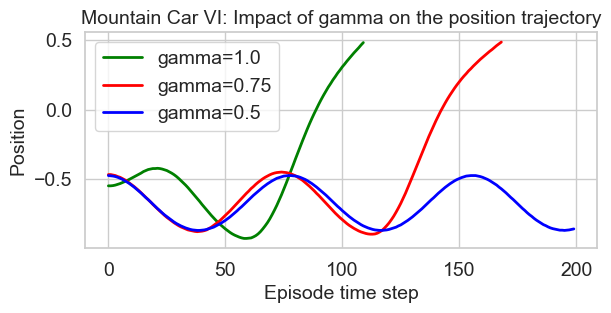

In [21]:
position_range = (-1.2, 0.6)
position_bins = 1000
velocity_bins = 1000 

fontsize = 14
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.45])

#test policy
test_scores, test_state_history = test_env_mc(env=mountaincar1000, n_iters=10000, pi=pi3)
print('Total reward Mean: ', np.mean(test_scores), ', std: ', np.std(test_scores), ', max: ', np.max(test_scores), ', min: ', np.min(test_scores))
idx = np.abs(test_scores - np.mean(test_scores)).argmin()
avg_position_history = index_to_position_list(test_state_history[idx], position_range, position_bins, velocity_bins)
ax.plot(range(len(avg_position_history)), avg_position_history, label='gamma=1.0', color='green',linewidth=2)

test_scores, test_state_history = test_env_mc(env=mountaincar1000, n_iters=10000, pi=pi3g07)
print('Total reward Mean: ', np.mean(test_scores), ', std: ', np.std(test_scores), ', max: ', np.max(test_scores), ', min: ', np.min(test_scores))
idx = np.abs(test_scores - np.mean(test_scores)).argmin()
avg_position_history = index_to_position_list(test_state_history[idx], position_range, position_bins, velocity_bins)
ax.plot(range(len(avg_position_history)), avg_position_history, label='gamma=0.75', color='red',linewidth=2)

test_scores, test_state_history = test_env_mc(env=mountaincar1000, n_iters=10000, pi=pi3g05)
print('Total reward Mean: ', np.mean(test_scores), ', std: ', np.std(test_scores), ', max: ', np.max(test_scores), ', min: ', np.min(test_scores))
idx = np.abs(test_scores - np.mean(test_scores)).argmin()
avg_position_history = index_to_position_list(test_state_history[idx], position_range, position_bins, velocity_bins)
ax.plot(range(len(avg_position_history)), avg_position_history, label='gamma=0.5', color='blue',linewidth=2)

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car VI: Impact of gamma on the position trajectory', fontsize=fontsize)
ax.set_xlabel('Episode time step', fontsize=fontsize) 
ax.set_ylabel('Position', fontsize=fontsize)
#ax.set_xlim(0, 15000)
plt.grid(True)
#ax.set_ylim(0.2, 1)
ax.legend(fontsize=fontsize)
plt.show()
fig.savefig('mc_history_gamma.png')
plt.close(fig)

Text(0.5, 1.0, 'Value function for state space 1000x1000')

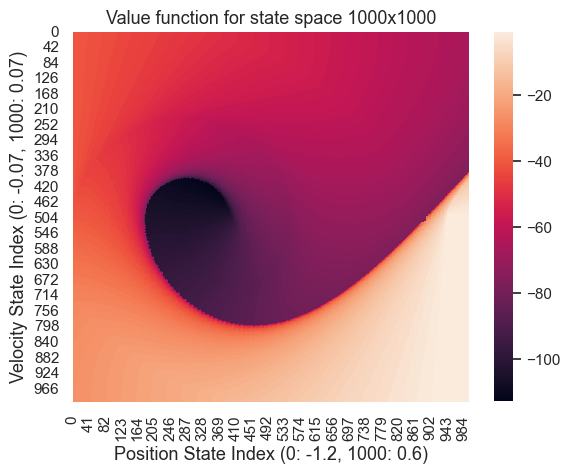

In [100]:
data = V3
size = (1000,1000)
data = np.array(data).reshape(size).T
df = pd.DataFrame(data=data)

ax=sns.heatmap(df, annot=False) #cmap=sns.color_palette("Blues", as_cmap=True), vmin=-40, vmax=0
ax.set_xlabel('Position State Index (0: -1.2, 1000: 0.6)', fontsize=13) 
ax.set_ylabel('Velocity State Index (0: -0.07, 1000: 0.07)', fontsize=13)
ax.set_title('Value function for state space 1000x1000', fontsize=13)

Text(0.5, 1.0, 'Optimal policy for state space 1000x1000')

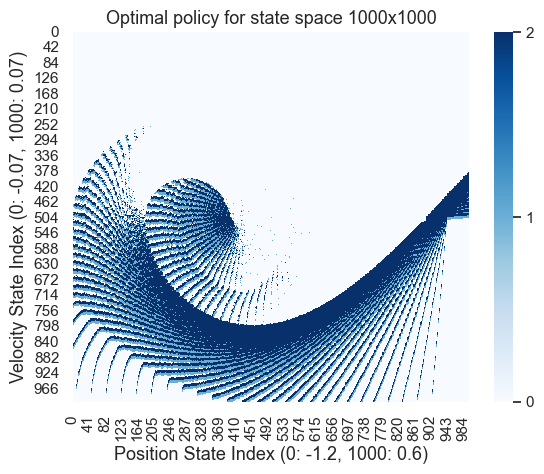

In [101]:
V=V3
pi=pi3

best_action = np.zeros(V.shape[0], dtype=np.int32)
for idx, val in enumerate(V):
    best_action[idx] = pi[idx]

data = best_action
size = (1000,1000)
data = np.array(data).reshape(size).T
df = pd.DataFrame(data=data)
ax=sns.heatmap(df, annot=False, cmap=sns.color_palette("Blues", as_cmap=True),
           cbar_kws={"ticks": [0, 1, 2]})
ax.set_xlabel('Position State Index (0: -1.2, 1000: 0.6)', fontsize=13) 
ax.set_ylabel('Velocity State Index (0: -0.07, 1000: 0.07)', fontsize=13)
ax.set_title('Optimal policy for state space 1000x1000', fontsize=13)

In [26]:
#test policy
test_scores, test_state_history = test_env_mc(env=mountaincar1000, n_iters=10000, pi=pi3)
print('Total reward Mean: ', np.mean(test_scores), ', std: ', np.std(test_scores), ', max: ', np.max(test_scores), ', min: ', np.min(test_scores))

max_rwrd_idx = np.argmax(test_scores)
min_rwrd_idx = np.argmin(test_scores)
avg_rwrd_idx = np.abs(test_scores - np.mean(test_scores)).argmin()

position_range = (-1.2, 0.6)
position_bins = 1000
velocity_bins = 1000 
max_position_history = index_to_position_list( test_state_history[max_rwrd_idx], position_range, position_bins, velocity_bins)
min_position_history = index_to_position_list( test_state_history[min_rwrd_idx], position_range, position_bins, velocity_bins)
avg_position_history = index_to_position_list( test_state_history[avg_rwrd_idx], position_range, position_bins, velocity_bins)

Total reward Mean:  -109.628 , std:  17.4622053590032 , max:  -85.0 , min:  -164.0


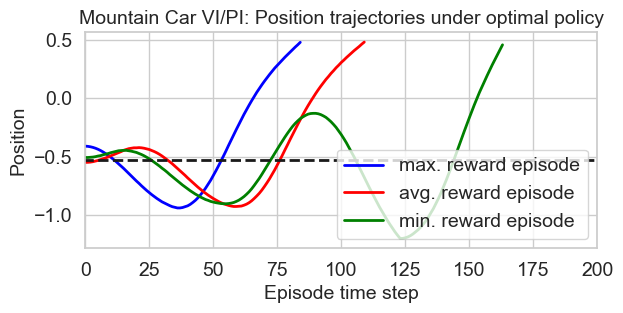

In [28]:
fontsize = 14
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.45])
ax.plot(range(len(max_position_history)), max_position_history, label=f'max. reward episode', color='blue', linewidth=2)
ax.plot(range(len(avg_position_history)), avg_position_history, label=f'avg. reward episode', color='red', linewidth=2)
ax.plot(range(len(min_position_history)), min_position_history, label=f'min. reward episode', color='green', linewidth=2)
ax.plot([-1, 200], [-0.5236, -0.5236], '--', color='k', linewidth=2)
ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car VI/PI: Position trajectories under optimal policy', fontsize=fontsize)
ax.set_xlabel('Episode time step', fontsize=fontsize) 
ax.set_ylabel('Position', fontsize=fontsize)
ax.set_xlim(-0, 200)
plt.grid(True)
#ax.set_ylim(0.2, 1)
ax.legend(fontsize=14, loc='lower right')
plt.show()
fig.savefig('mc_vi_pi_optimal_position_hist.png')
plt.close(fig)

#### Policy Iteration

In [22]:
space_dims = (200, 200)

print('Running PI')
# run PI
tic = time.perf_counter()
V, V_track, pi, pi_track = PlannerR(mountaincar200.P, mountaincar200).policy_iteration(gamma=0.98, n_iters=100, theta=1e-10)
toc = time.perf_counter()
print('PI runtime', toc-tic)

Running PI
PI runtime 182.2179953000741


NameError: name 'V_track_PI' is not defined

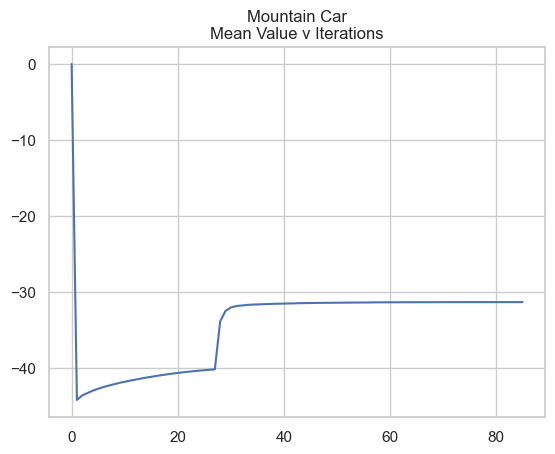

Computing expected reward history


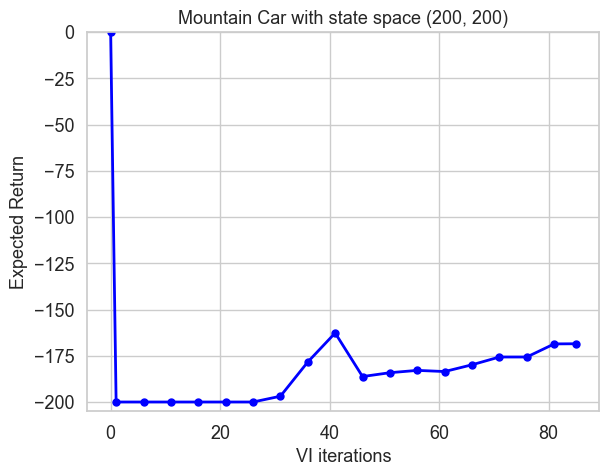

In [25]:
# Clip trailing zeros in case convergence is reached before max iterations
# This is likely when setting the n_iters parameter
mean_v_per_iter = np.trim_zeros(np.mean(V_track, axis=1), 'b')
Plots.v_iters_plot(mean_v_per_iter, "Mountain Car\nMean Value v Iterations")

print('Computing expected reward history')
R_track = expected_reward_history(space_dims=space_dims, pi_track=pi_track, output_step=5, n_episodes=10000, nproc=12)
R_track[:, 0] = R_track[:, 0] + 1
row_of_zeros = np.zeros((1, 3))
R_track = np.vstack((row_of_zeros, R_track))

V_track_pi1 = V_track 
R_track_pi1 = R_track
V_pi1 = V
pi_pi1 = pi 
pi_track_pi1 = pi_track

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(R_track[:,0], R_track[:,1], '-o', color='blue', markersize=5, linewidth=2)

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car with state space (200, 200)', fontsize=fontsize)
ax.set_xlabel('VI iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
#ax.legend(fontsize=fontsize)
ax.set_ylim(-205, 0)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

In [27]:
space_dims = (500, 500)

print('Running PI')
# run PI
tic = time.perf_counter()
V, V_track, pi, pi_track = PlannerR(mountaincar500.P, mountaincar500).policy_iteration(gamma=0.95, n_iters=200, theta=1e-10)
toc = time.perf_counter()
print('PI runtime', toc-tic)


Running PI
PI runtime 1617.3002354999771


NameError: name 'V_track_PI' is not defined

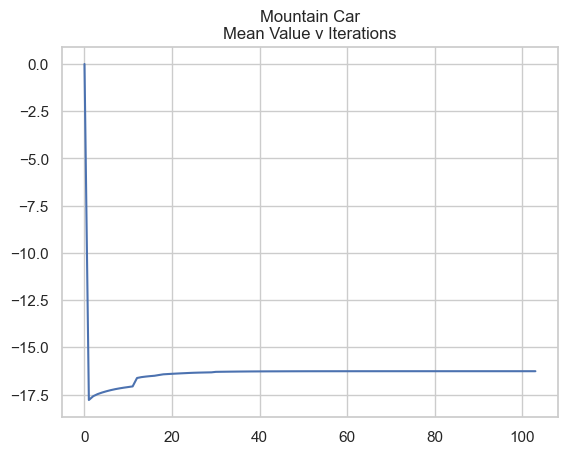

Computing expected reward history


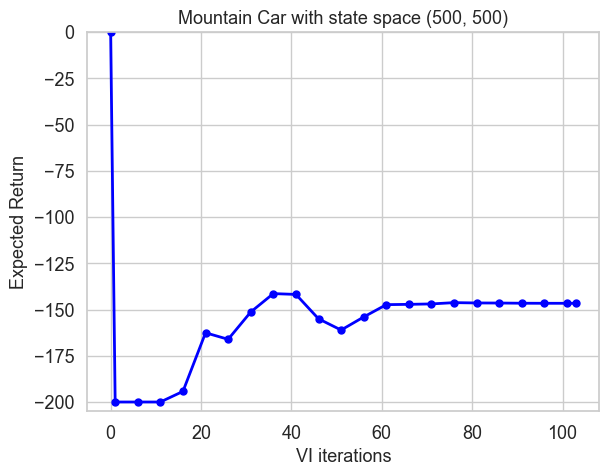

In [28]:
# Clip trailing zeros in case convergence is reached before max iterations
# This is likely when setting the n_iters parameter
mean_v_per_iter = np.trim_zeros(np.mean(V_track, axis=1), 'b')
Plots.v_iters_plot(mean_v_per_iter, "Mountain Car\nMean Value v Iterations")

print('Computing expected reward history')
R_track = expected_reward_history(space_dims=space_dims, pi_track=pi_track, output_step=5, n_episodes=10000, nproc=22)
R_track[:, 0] = R_track[:, 0] + 1
row_of_zeros = np.zeros((1, 3))
R_track = np.vstack((row_of_zeros, R_track))

V_track_pi2 = V_track 
R_track_pi2 = R_track
V_pi2 = V
pi_pi2 = pi 
pi_track_pi2 = pi_track

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(R_track[:,0], R_track[:,1], '-o', color='blue', markersize=5, linewidth=2)

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car with state space (500, 500)', fontsize=fontsize)
ax.set_xlabel('VI iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
#ax.legend(fontsize=fontsize)
ax.set_ylim(-205, 0)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

Running PI
PI runtime 7302.930039300001


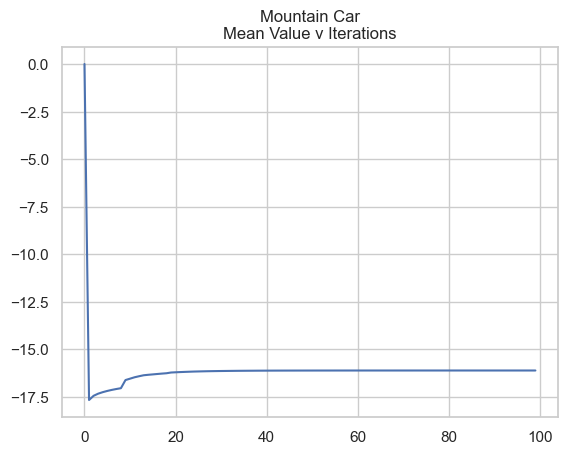

Computing expected reward history


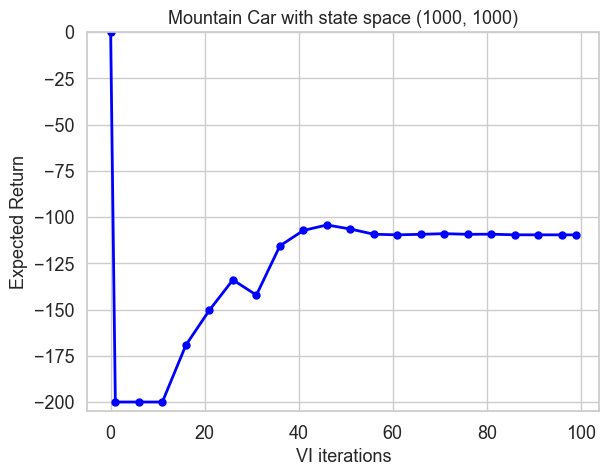

In [29]:
space_dims = (1000, 1000)

print('Running PI')
# run PI
tic = time.perf_counter()
V, V_track, pi, pi_track = PlannerR(mountaincar1000.P, mountaincar1000).policy_iteration(gamma=0.95, n_iters=200, theta=1e-10)
toc = time.perf_counter()
print('PI runtime', toc-tic)

# Clip trailing zeros in case convergence is reached before max iterations
# This is likely when setting the n_iters parameter
mean_v_per_iter = np.trim_zeros(np.mean(V_track, axis=1), 'b')
Plots.v_iters_plot(mean_v_per_iter, "Mountain Car\nMean Value v Iterations")

print('Computing expected reward history')
R_track = expected_reward_history(space_dims=space_dims, pi_track=pi_track, output_step=5, n_episodes=10000, nproc=22)
R_track[:, 0] = R_track[:, 0] + 1
row_of_zeros = np.zeros((1, 3))
R_track = np.vstack((row_of_zeros, R_track))

V_track_pi3 = V_track 
R_track_pi3 = R_track
V_pi3 = V
pi_pi3 = pi 
pi_track_pi3 = pi_track 

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(R_track[:,0], R_track[:,1], '-o', color='blue', markersize=5, linewidth=2)

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car with state space (1000, 500)', fontsize=fontsize)
ax.set_xlabel('VI iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
#ax.legend(fontsize=fontsize)
ax.set_ylim(-205, 0)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

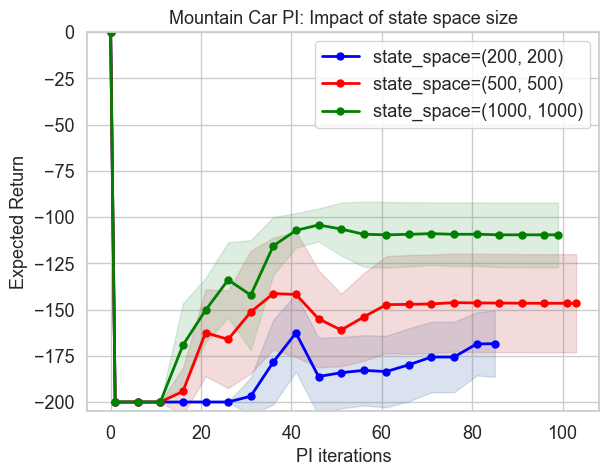

In [30]:
fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(R_track_pi1[:,0], R_track_pi1[:,1], '-o', color='blue', label='state_space=(200, 200)', markersize=5, linewidth=2)
ax.fill_between(R_track_pi1[:,0], R_track_pi1[:,1]-R_track_pi1[:,2], R_track_pi1[:,1]+R_track_pi1[:,2], alpha=0.2, color="b")

ax.plot(R_track_pi2[:,0], R_track_pi2[:,1], '-o', color='red', label='state_space=(500, 500)', markersize=5, linewidth=2)
ax.fill_between(R_track_pi2[:,0], R_track_pi2[:,1]-R_track_pi2[:,2], R_track_pi2[:,1]+R_track_pi2[:,2], alpha=0.2, color="r")

ax.plot(R_track_pi3[:,0], R_track_pi3[:,1], '-o', color='green', label='state_space=(1000, 1000)', markersize=5, linewidth=2)
ax.fill_between(R_track_pi3[:,0], R_track_pi3[:,1]-R_track_pi3[:,2], R_track_pi3[:,1]+R_track_pi3[:,2], alpha=0.2, color="g")

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car PI: Impact of state space size', fontsize=fontsize)
ax.set_xlabel('PI iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
ax.legend(fontsize=fontsize)
ax.set_ylim(-205, 0)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

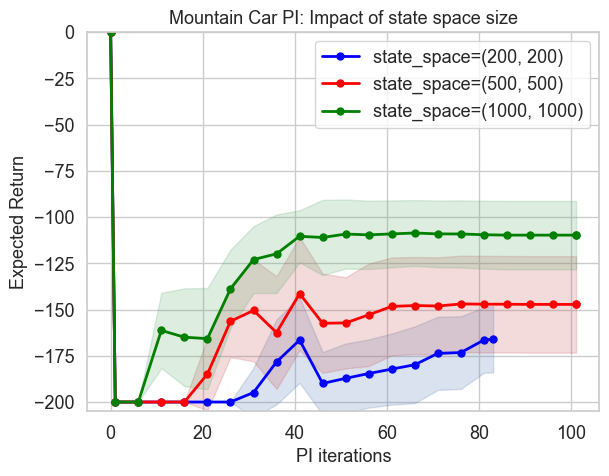

In [72]:
fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(R_track_pi1[:,0], R_track_pi1[:,1], '-o', color='blue', label='state_space=(200, 200)', markersize=5, linewidth=2)
ax.fill_between(R_track_pi1[:,0], R_track_pi1[:,1]-R_track_pi1[:,2], R_track_pi1[:,1]+R_track_pi1[:,2], alpha=0.2, color="b")

ax.plot(R_track_pi2[:,0], R_track_pi2[:,1], '-o', color='red', label='state_space=(500, 500)', markersize=5, linewidth=2)
ax.fill_between(R_track_pi2[:,0], R_track_pi2[:,1]-R_track_pi2[:,2], R_track_pi2[:,1]+R_track_pi2[:,2], alpha=0.2, color="r")

ax.plot(R_track_pi3[:,0], R_track_pi3[:,1], '-o', color='green', label='state_space=(1000, 1000)', markersize=5, linewidth=2)
ax.fill_between(R_track_pi3[:,0], R_track_pi3[:,1]-R_track_pi3[:,2], R_track_pi3[:,1]+R_track_pi3[:,2], alpha=0.2, color="g")

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car PI: Impact of state space size', fontsize=fontsize)
ax.set_xlabel('PI iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
ax.legend(fontsize=fontsize)
ax.set_ylim(-205, 0)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

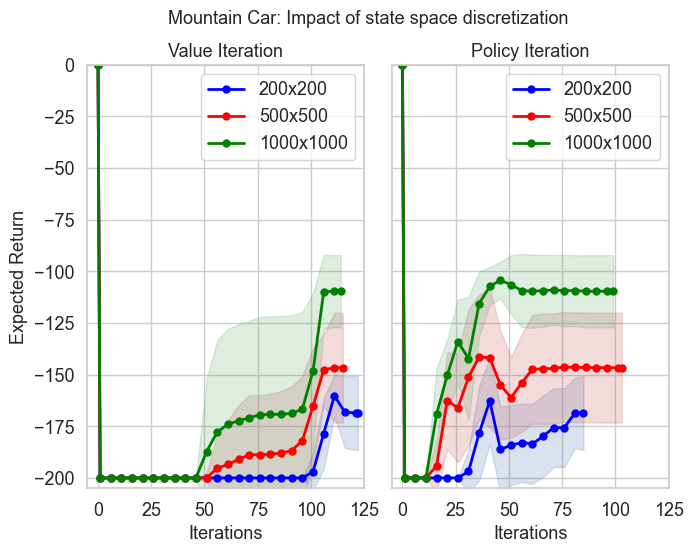

In [68]:
fontsize = 13
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(7.5, 5.5))

ax1.plot(R_track1[:,0], R_track1[:,1], '-o', color='blue', label='200x200', markersize=5, linewidth=2)
ax1.fill_between(R_track1[:,0], R_track1[:,1]-R_track1[:,2], R_track1[:,1]+R_track1[:,2], alpha=0.2, color="b")

ax1.plot(R_track2[:,0], R_track2[:,1], '-o', color='red', label='500x500', markersize=5, linewidth=2)
ax1.fill_between(R_track2[:,0], R_track2[:,1]-R_track2[:,2], R_track2[:,1]+R_track2[:,2], alpha=0.2, color="r")

ax1.plot(R_track3[:,0], R_track3[:,1], '-o', color='green', label='1000x1000', markersize=5, linewidth=2)
ax1.fill_between(R_track3[:,0], R_track3[:,1]-R_track3[:,2], R_track3[:,1]+R_track3[:,2], alpha=0.2, color="g")

ax1.tick_params(labelsize=fontsize)
ax1.set_title('Value Iteration', fontsize=fontsize)
ax1.set_xlabel('Iterations', fontsize=fontsize) 
ax1.set_ylabel('Expected Return', fontsize=fontsize)
ax1.set_xlim(-5, 125)
ax1.set_xticks([0, 25, 50, 75, 100, 125])
ax1.grid(True)
ax1.legend(fontsize=fontsize)
ax1.set_ylim(-205, 0)
#plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
#plt.close(fig)


ax2.plot(R_track_pi1[:,0], R_track_pi1[:,1], '-o', color='blue', label='200x200', markersize=5, linewidth=2)
ax2.fill_between(R_track_pi1[:,0], R_track_pi1[:,1]-R_track_pi1[:,2], R_track_pi1[:,1]+R_track_pi1[:,2], alpha=0.2, color="b")

ax2.plot(R_track_pi2[:,0], R_track_pi2[:,1], '-o', color='red', label='500x500', markersize=5, linewidth=2)
ax2.fill_between(R_track_pi2[:,0], R_track_pi2[:,1]-R_track_pi2[:,2], R_track_pi2[:,1]+R_track_pi2[:,2], alpha=0.2, color="r")

ax2.plot(R_track_pi3[:,0], R_track_pi3[:,1], '-o', color='green', label='1000x1000', markersize=5, linewidth=2)
ax2.fill_between(R_track_pi3[:,0], R_track_pi3[:,1]-R_track_pi3[:,2], R_track_pi3[:,1]+R_track_pi3[:,2], alpha=0.2, color="g")

ax2.tick_params(labelsize=fontsize)
ax2.set_title('Policy Iteration', fontsize=fontsize)
ax2.set_xlabel('Iterations', fontsize=fontsize) 
#ax2.set_ylabel('Expected Return', fontsize=fontsize)
ax2.set_xticks([0, 25, 50, 75, 100, 125])
ax2.grid(True)
ax2.legend(fontsize=fontsize)
ax2.set_ylim(-205, 0)
ax2.set_xlim(-5, 125)

fig.suptitle('Mountain Car: Impact of state space discretization', fontsize=fontsize) 
fig.subplots_adjust(wspace=0.1)
plt.show()
fig.savefig('mc_vi_pi_discr.png')
plt.close(fig)

In [75]:
print(R_track1[-1,1], R_track2[-1,1], R_track3[-1,1])
print(R_track_pi1[-1,1], R_track_pi2[-1,1], R_track_pi3[-1,1])

print(R_track3[-1,1], R_track3g05[-1,1], R_track3g07[-1,1])
print(R_track_pi3[-1,1], R_track_pi3_g05[-1,1])

-168.5117 -146.6357 -109.628
-168.5117 -146.6357 -109.628
-109.628 -180.9499 -169.2486
-109.628 -180.9499


In [10]:
#test policy
test_scores, _ = test_env_mc(env=mountaincar200, n_iters=100, pi=pi_pi1)
print('Total reward Mean: ', np.mean(test_scores), ', std: ', np.std(test_scores), ', max: ', np.max(test_scores), ', min: ', np.min(test_scores))

test_scores, _ = test_env_mc(env=mountaincar500, n_iters=100, pi=pi_pi2)
print('Total reward Mean: ', np.mean(test_scores), ', std: ', np.std(test_scores), ', max: ', np.max(test_scores), ', min: ', np.min(test_scores))

test_scores, test_state_history = test_env_mc(env=mountaincar1000, n_iters=100, pi=pi_pi3)
print('Total reward Mean: ', np.mean(test_scores), ', std: ', np.std(test_scores), ', max: ', np.max(test_scores), ', min: ', np.min(test_scores))

max_rwrd_idx = np.argmax(test_scores)
min_rwrd_idx = np.argmin(test_scores)
avg_rwrd_idx = np.abs(test_scores - np.mean(test_scores)).argmin()

position_range = (-1.2, 0.6)
position_bins = 1000
velocity_bins = 1000 
max_position_history = index_to_position_list( test_state_history[max_rwrd_idx], position_range, position_bins, velocity_bins)
min_position_history = index_to_position_list( test_state_history[min_rwrd_idx], position_range, position_bins, velocity_bins)
avg_position_history = index_to_position_list( test_state_history[avg_rwrd_idx], position_range, position_bins, velocity_bins)

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.6])
ax.plot(range(len(max_position_history)), max_position_history, label=f'max. reward episode', color='blue')
ax.plot(range(len(avg_position_history)), avg_position_history, label=f'mean reward episode', color='red')
ax.plot(range(len(min_position_history)), min_position_history, label=f'min. reward episode', color='green')
ax.plot([-1, 160], [-0.5236, -0.5236], '--', color='k')
ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car VI: Position histories with optimal policy', fontsize=fontsize)
ax.set_xlabel('Episode step', fontsize=fontsize) 
ax.set_ylabel('Position', fontsize=fontsize)
ax.set_xlim(-1, 150)
plt.grid(True)
#ax.set_ylim(0.2, 1)
ax.legend(fontsize=fontsize)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

NameError: name 'pi_pi1' is not defined

Running PI
PI runtime 767.9254119000398


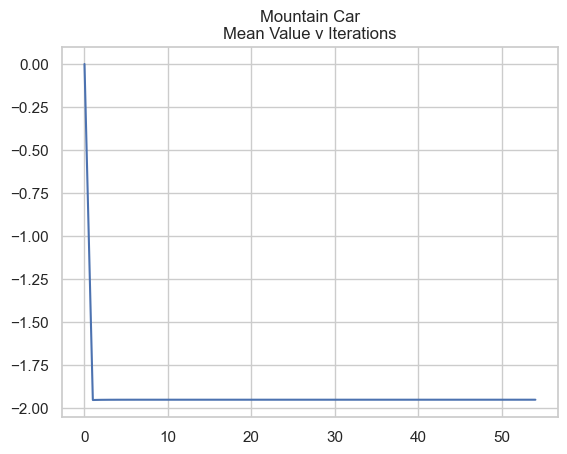

Computing expected reward history


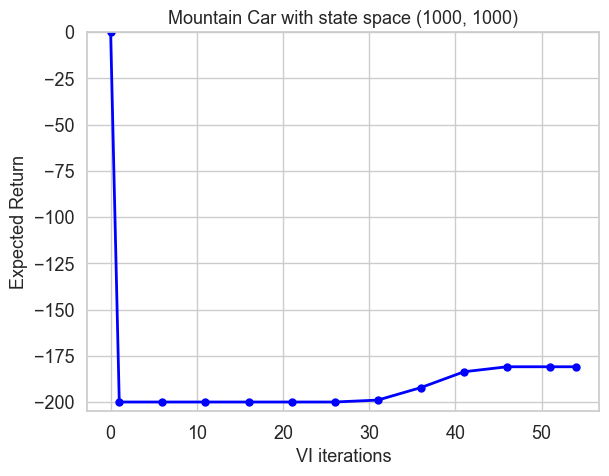

In [65]:
space_dims = (1000, 1000)

print('Running PI')
# run PI
tic = time.perf_counter()
V, V_track, pi, pi_track = PlannerR(mountaincar1000.P, mountaincar1000).policy_iteration(gamma=0.50, n_iters=150, theta=1e-10)
toc = time.perf_counter()
print('PI runtime', toc-tic)

# Clip trailing zeros in case convergence is reached before max iterations
# This is likely when setting the n_iters parameter
mean_v_per_iter = np.trim_zeros(np.mean(V_track, axis=1), 'b')
Plots.v_iters_plot(mean_v_per_iter, "Mountain Car\nMean Value v Iterations")

print('Computing expected reward history')
R_track = expected_reward_history(space_dims=space_dims, pi_track=pi_track, output_step=5, n_episodes=10000, nproc=18)
R_track[:, 0] = R_track[:, 0] + 1
row_of_zeros = np.zeros((1, 3))
R_track = np.vstack((row_of_zeros, R_track))

V_track_pi3_g05 = V_track 
R_track_pi3_g05 = R_track
V_pi3_g05 = V
pi_pi3_g05 = pi 
pi_track_pi3_g05 = pi_track

fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(R_track[:,0], R_track[:,1], '-o', color='blue', markersize=5, linewidth=2)

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car with state space (1000, 1000)', fontsize=fontsize)
ax.set_xlabel('VI iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
#ax.legend(fontsize=fontsize)
ax.set_ylim(-205, 0)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

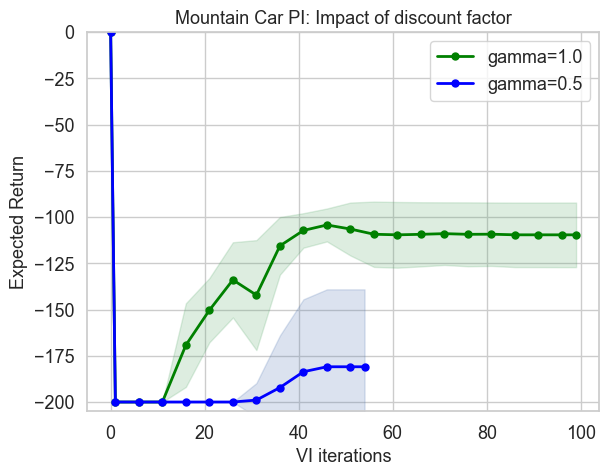

In [66]:
fontsize = 13
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(R_track_pi3[:,0], R_track_pi3[:,1], '-o', color='green', label='gamma=1.0', markersize=5, linewidth=2)
ax.fill_between(R_track_pi3[:,0], R_track_pi3[:,1]-R_track_pi3[:,2], R_track_pi3[:,1]+R_track_pi3[:,2], alpha=0.2, color="g")

#ax.plot(R_track3g07[:,0], R_track3g07[:,1], '-o', color='red', label='gamma=0.75', markersize=5, linewidth=2)
#ax.fill_between(R_track3g07[:,0], R_track3g07[:,1]-R_track3g07[:,2], R_track3g07[:,1]+R_track3g07[:,2], alpha=0.2, color="r")

ax.plot(R_track_pi3_g05[:,0], R_track_pi3_g05[:,1], '-o', color='blue', label='gamma=0.5', markersize=5, linewidth=2)
ax.fill_between(R_track_pi3_g05[:,0], R_track_pi3_g05[:,1]-R_track_pi3_g05[:,2], R_track_pi3_g05[:,1]+R_track_pi3_g05[:,2], alpha=0.2, color="b")

ax.tick_params(labelsize=fontsize)
ax.set_title('Mountain Car PI: Impact of discount factor', fontsize=fontsize)
ax.set_xlabel('VI iterations', fontsize=fontsize) 
ax.set_ylabel('Expected Return', fontsize=fontsize)
#ax.set_xlim(0, 150000)
plt.grid(True)
ax.legend(fontsize=fontsize)
ax.set_ylim(-205, 0)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

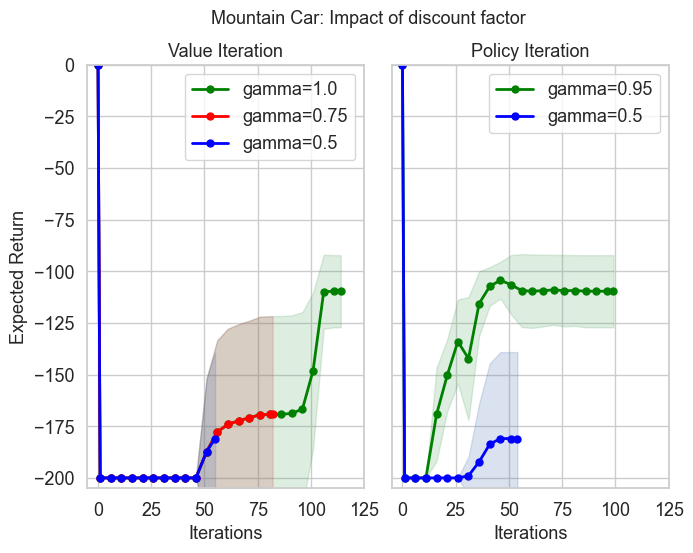

In [74]:
fontsize = 13
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(7.5, 5.5))

ax1.plot(R_track3[:,0], R_track3[:,1], '-o', color='green', label='gamma=1.0', markersize=5, linewidth=2)
ax1.fill_between(R_track3[:,0], R_track3[:,1]-R_track3[:,2], R_track3[:,1]+R_track3[:,2], alpha=0.2, color="g")

ax1.plot(R_track3g07[:,0], R_track3g07[:,1], '-o', color='red', label='gamma=0.75', markersize=5, linewidth=2)
ax1.fill_between(R_track3g07[:,0], R_track3g07[:,1]-R_track3g07[:,2], R_track3g07[:,1]+R_track3g07[:,2], alpha=0.2, color="r")

ax1.plot(R_track3g05[:,0], R_track3g05[:,1], '-o', color='blue', label='gamma=0.5', markersize=5, linewidth=2)
ax1.fill_between(R_track3g05[:,0], R_track3g05[:,1]-R_track3g05[:,2], R_track3g05[:,1]+R_track3g05[:,2], alpha=0.2, color="b")

ax1.tick_params(labelsize=fontsize)
ax1.set_title('Value Iteration', fontsize=fontsize)
ax1.set_xlabel('Iterations', fontsize=fontsize) 
ax1.set_ylabel('Expected Return', fontsize=fontsize)
ax1.set_xlim(-5, 125)
ax1.set_xticks([0, 25, 50, 75, 100, 125])
ax1.grid(True)
ax1.legend(fontsize=fontsize)
ax1.set_ylim(-205, 0)
#plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
#plt.close(fig)


ax2.plot(R_track_pi3[:,0], R_track_pi3[:,1], '-o', color='green', label='gamma=0.95', markersize=5, linewidth=2)
ax2.fill_between(R_track_pi3[:,0], R_track_pi3[:,1]-R_track_pi3[:,2], R_track_pi3[:,1]+R_track_pi3[:,2], alpha=0.2, color="g")

#ax.plot(R_track3g07[:,0], R_track3g07[:,1], '-o', color='red', label='gamma=0.75', markersize=5, linewidth=2)
#ax.fill_between(R_track3g07[:,0], R_track3g07[:,1]-R_track3g07[:,2], R_track3g07[:,1]+R_track3g07[:,2], alpha=0.2, color="r")

ax2.plot(R_track_pi3_g05[:,0], R_track_pi3_g05[:,1], '-o', color='blue', label='gamma=0.5', markersize=5, linewidth=2)
ax2.fill_between(R_track_pi3_g05[:,0], R_track_pi3_g05[:,1]-R_track_pi3_g05[:,2], R_track_pi3_g05[:,1]+R_track_pi3_g05[:,2], alpha=0.2, color="b")

ax2.tick_params(labelsize=fontsize)
ax2.set_title('Policy Iteration', fontsize=fontsize)
ax2.set_xlabel('Iterations', fontsize=fontsize) 
#ax2.set_ylabel('Expected Return', fontsize=fontsize)
ax2.set_xticks([0, 25, 50, 75, 100, 125])
ax2.grid(True)
ax2.legend(fontsize=fontsize)
ax2.set_ylim(-205, 0)
ax2.set_xlim(-5, 125)

fig.suptitle('Mountain Car: Impact of discount factor', fontsize=fontsize) 
fig.subplots_adjust(wspace=0.1)
plt.show()
fig.savefig('mc_vi_pi_gamma.png')
plt.close(fig)

<Axes: >

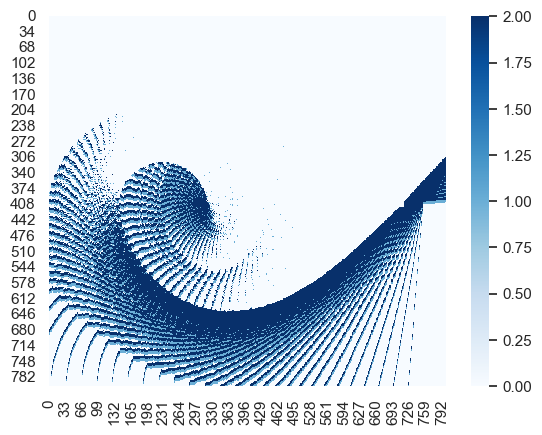

In [15]:
best_action = np.zeros(V800.shape[0], dtype=np.int32)
for idx, val in enumerate(V800):
    best_action[idx] = pi800[idx]

data = best_action
size = (800,800)
data = np.array(data).reshape(size).T
df = pd.DataFrame(data=data)
sns.heatmap(df, annot=False, cmap=sns.color_palette("Blues", as_cmap=True),)

In [16]:
np.savetxt('pi800.txt', best_action, delimiter=',')
np.savetxt('mean_V_track800.txt', np.mean(V_track800, axis=1), delimiter=',')
np.savetxt('R_track800.txt', R_track800, delimiter=',')

Total reward Mean:  -110.33 , std:  18.5062448919277 , max:  -86.0 , min:  -150.0


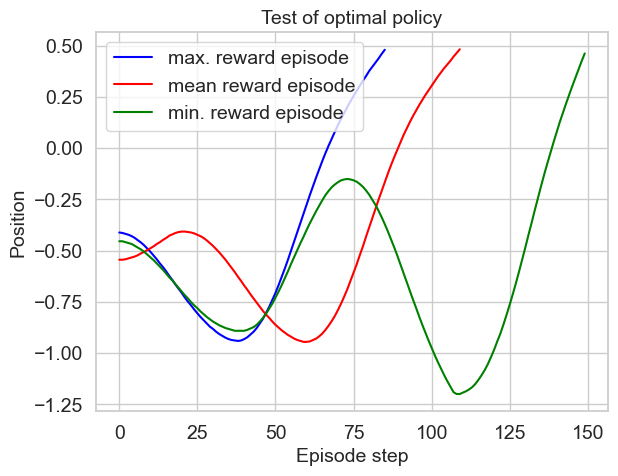

In [20]:
#test policy
test_scores, test_state_history = test_env_mc(env=mountaincar800, n_iters=100, pi=pi800)
print('Total reward Mean: ', np.mean(test_scores), ', std: ', np.std(test_scores), ', max: ', np.max(test_scores), ', min: ', np.min(test_scores))

max_rwrd_idx = np.argmax(test_scores)
min_rwrd_idx = np.argmin(test_scores)
avg_rwrd_idx = np.abs(test_scores - np.mean(test_scores)).argmin()

position_range = (-1.2, 0.6)
position_bins = 800
velocity_bins = 800 
max_position_history = index_to_position_list( test_state_history[max_rwrd_idx], position_range, position_bins, velocity_bins)
min_position_history = index_to_position_list( test_state_history[min_rwrd_idx], position_range, position_bins, velocity_bins)
avg_position_history = index_to_position_list( test_state_history[avg_rwrd_idx], position_range, position_bins, velocity_bins)

fontsize = 14
fig = plt.figure()
ax = fig.add_axes([0.15, 0.14, 0.80, 0.79])
ax.plot(range(len(max_position_history)), max_position_history, label=f'max. reward episode', color='blue')
ax.plot(range(len(avg_position_history)), avg_position_history, label=f'mean reward episode', color='red')
ax.plot(range(len(min_position_history)), min_position_history, label=f'min. reward episode', color='green')
ax.tick_params(labelsize=fontsize)
ax.set_title('Test of optimal policy', fontsize=fontsize)
ax.set_xlabel('Episode step', fontsize=fontsize) 
ax.set_ylabel('Position', fontsize=fontsize)
#ax.set_xlim(0, 15000)
plt.grid(True)
#ax.set_ylim(0.2, 1)
ax.legend(fontsize=fontsize)
plt.show()
#fig.savefig('rhc_effect_max_attempts.png')
plt.close(fig)

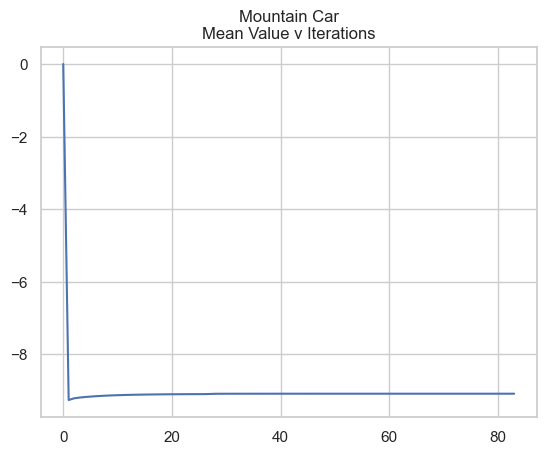

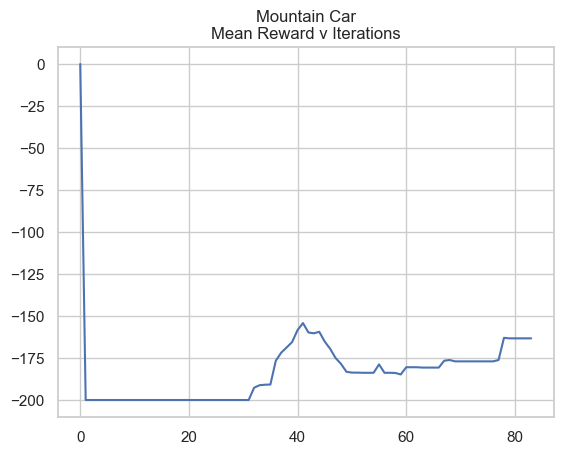

In [21]:
# run PI
V_PI800, V_track_PI800, pi_PI800, R_track_PI800 = PlannerR(mountaincar800.P, mountaincar800).policy_iteration(gamma=0.9, n_iters=100, theta=1e-10)

# Clip trailing zeros in case convergence is reached before max iterations
# This is likely when setting the n_iters parameter
mean_v_per_iter = np.trim_zeros(np.mean(V_track_PI, axis=1), 'b')
Plots.v_iters_plot(mean_v_per_iter, "Mountain Car\nMean Value v Iterations")

mean_r_per_iter = np.trim_zeros(R_track_PI, 'b')
Plots.v_iters_plot(mean_r_per_iter, "Mountain Car\nMean Reward v Iterations")

In [ ]:
# Q-learning
Q, V, pi, Q_track, pi_track = RL(cartpole).q_learning()

#test policy
test_scores = TestEnv.test_env(env=cartpole, n_iters=100, render=False, pi=pi, user_input=False)
print(np.mean(test_scores))